<a href="https://colab.research.google.com/github/MariaanaT/Higgs-DNN/blob/master/Higgs_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Searching Higgs boson with deep neural network

This work aims to replicate work presented in paper *Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).* Nevertheless, the original paper uses Pylearn2 to train neural networks, but Tensorflow and Keras are used in this work. 

The dataset can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS). Data set description can be found from the article. See also [code in GitHub](https://github.com/uci-igb/higgs-susy) used in the original work. 

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

### Load dataset 

Get dataset from Google Drive. Needed only when working with Google Colab. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset. We need only the class label and low level features, that is, columns 1-22. High level features which have been derived from low level features, are in columns 23-29 and are left out. 

In [10]:
#path = 'HIGGS.csv.gz' #link in own computer
path = '/content/drive/My Drive/datasets/HIGGS.csv.gz' #link in Google Drive
nrows = 2500000
dataset = pd.read_csv(path, 
                      compression='gzip', 
                      usecols = list(range(0,22)), 
                      nrows = nrows,
                      header = None)

Print the firs few roads to make sure loading was done correctly. 

In [11]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


Rename columns to be more descriptive. More details can be found from the original article.

In [12]:
dataset.columns = ['class label', 'lepton pT', 'lepton eta', 'lepton phi', 
                   'missing energy magnitude', 'missing energy phi',
                   'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
                   'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                   'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 
                   'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag']

Print summary of the dataset. 

In [13]:
dataset.describe()

,class label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
count,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06
mean,5.295332e-01,9.909514e-01,1.955417e-04,-3.169489e-05,9.983776e-01,-6.830571e-04,9.905267e-01,-5.209604e-04,3.227783e-04,1.001191e+00,9.925799e-01,1.100517e-03,5.171682e-04,9.992227e-01,9.920353e-01,8.544650e-04,1.823075e-04,1.000605e+00,9.858104e-01,-2.411817e-04,-1.268937e-04,9.988123e-01
std,4.991271e-01,5.648552e-01,1.008700e+00,1.006230e+00,5.997689e-01,1.006398e+00,4.743167e-01,1.009432e+00,1.006093e+00,1.027907e+00,5.001791e-01,1.009579e+00,1.006245e+00,1.049261e+00,4.870261e-01,1.008089e+00,1.006146e+00,1.193923e+00,5.056916e-01,1.007806e+00,1.006446e+00,1.399678e+00
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,6.259872e-04,-1.743944e+00,1.378689e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00
25%,0.000000e+00,5.902043e-01,-7.383225e-01,-8.719308e-01,5.766077e-01,-8.714912e-01,6.791759e-01,-6.872450e-01,-8.675418e-01,0.000000e+00,6.565868e-01,-6.944718e-01,-8.690695e-01,0.000000e+00,6.506770e-01,-6.979879e-01,-8.711343e-01,0.000000e+00,6.170371e-01,-7.141902e-01,-8.720338e-01,0.000000e+00
50%,1.000000e+00,8.530054e-01,9.198132e-04,9.714414e-04,8.914129e-01,-1.253696e-03,8.943613e-01,-1.015666e-03,5.813991e-05,1.086538e+00,8.900118e-01,1.031646e-03,1.009147e-03,0.000000e+00,8.972494e-01,1.083142e-03,-1.972152e-04,0.000000e+00,8.677465e-01,-4.606903e-04,-8.191102e-04,0.000000e+00
75%,1.000000e+00,1.235860e+00,7.382142e-01,8.709940e-01,1.292830e+00,8.710670e-01,1.170557e+00,6.871941e-01,8.688670e-01,2.173076e+00,1.201623e+00,6.965352e-01,8.704274e-01,2.214872e+00,1.221622e+00,7.001541e-01,8.713947e-01,2.548224e+00,1.221174e+00,7.141017e-01,8.716055e-01,3.101961e+00
max,1.000000e+00,9.690881e+00,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,8.848616e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,8.864838e+00,2.730009e+00,1.742884e+00,2.548224e+00,1.162123e+01,2.498009e+00,1.743372e+00,3.101961e+00


###  Separate input and output variables 

Split dataset into input (X) and output (y) variables. Trivially, class label is the output variable.

In [14]:
X = dataset.iloc[:,1:23]
y = dataset.iloc[:,0] 
X.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


### Define neural network architecture 

Define constants for NN architecture. 

In [15]:
noInputUnits = X.shape[1]
noHiddenUnits = 300
learningRate = 0.05
learningRateDecay = 1.0000002
learningRateMin = 1e-6
weightDecay = 1e-5
batchSize = 100
noEpochs = 20
validationSplit = 0.3
#TODO TODO#
#weight initialization 

Define the neural network. 

In [16]:
model = Sequential()
model.add(Dense(noHiddenUnits, input_dim=noInputUnits, activation='tanh'))
model.add(Dense(noHiddenUnits, activation='tanh'))
model.add(Dense(noHiddenUnits, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               6600      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 187,501
Trainable params: 187,501
Non-trainable params: 0
_________________________________________________________________


Compile the keras NN model.

In [17]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

### Train neural network 

Fit the keras NN model on the dataset.

In [18]:
fittedModel = model.fit(X, y, 
                    validation_split = validationSplit,
                    epochs = noEpochs, 
                    batch_size = batchSize)

Epoch 1/20
17500/17500 [==============================] - 100s 6ms/step - loss: 0.6419 - accuracy: 0.6239 - val_loss: 0.6032 - val_accuracy: 0.6703
Epoch 2/20
17500/17500 [==============================] - 103s 6ms/step - loss: 0.6000 - accuracy: 0.6740 - val_loss: 0.5961 - val_accuracy: 0.6779
Epoch 3/20
17500/17500 [==============================] - 99s 6ms/step - loss: 0.5908 - accuracy: 0.6826 - val_loss: 0.5880 - val_accuracy: 0.6854
Epoch 4/20
17500/17500 [==============================] - 100s 6ms/step - loss: 0.5857 - accuracy: 0.6876 - val_loss: 0.5836 - val_accuracy: 0.6886
Epoch 5/20
17500/17500 [==============================] - 100s 6ms/step - loss: 0.5813 - accuracy: 0.6915 - val_loss: 0.5815 - val_accuracy: 0.6914
Epoch 6/20
17500/17500 [==============================] - 100s 6ms/step - loss: 0.5787 - accuracy: 0.6934 - val_loss: 0.5792 - val_accuracy: 0.6943
Epoch 7/20
17500/17500 [==============================] - 100s 6ms/step - loss: 0.5744 - accuracy: 0.6981 - val_l

### Evaluate neural network 

Evaluate the keras NN model. 

In [19]:
X_ = X.head(10000)
y_ = y.head(10000)
_, accuracy = model.evaluate(X.head(10000), y.head(10000))
print('Accuracy: %.2f' % (accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.5359 - accuracy: 0.7321
Accuracy: 73.21


Make class predictions with the NN model. 

In [20]:
predictions = model.predict_classes(X_)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Summarize the first cases. 

In [21]:
for i in range(20):
    print('Row %s => %d (expected %d)' % (i, predictions[i], y[i]))

Row 0 => 1 (expected 1)
Row 1 => 1 (expected 1)
Row 2 => 1 (expected 1)
Row 3 => 0 (expected 0)
Row 4 => 1 (expected 1)
Row 5 => 0 (expected 0)
Row 6 => 1 (expected 1)
Row 7 => 1 (expected 1)
Row 8 => 1 (expected 1)
Row 9 => 1 (expected 1)
Row 10 => 0 (expected 1)
Row 11 => 0 (expected 0)
Row 12 => 1 (expected 1)
Row 13 => 1 (expected 1)
Row 14 => 0 (expected 1)
Row 15 => 0 (expected 0)
Row 16 => 1 (expected 1)
Row 17 => 0 (expected 0)
Row 18 => 0 (expected 0)
Row 19 => 1 (expected 1)


In [22]:
# list all data available during model fitting
fittedModel.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot accuracy behavior during epochs. The training and testing phases should not be too much different, otherwise the model is overfitted. 

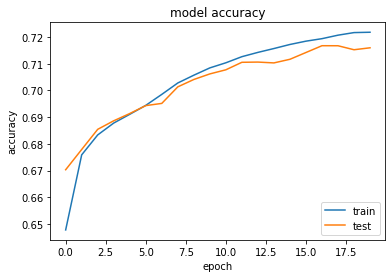

In [23]:
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Plot loss behavior during epochs. 

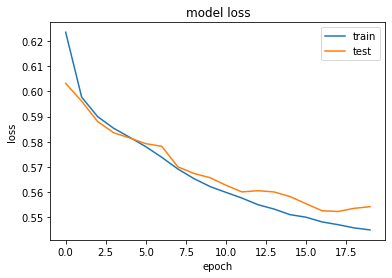

In [24]:
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()